In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from dotenv import load_dotenv
import os

load_dotenv(dotenv_path='../.env')
file_path = os.getenv('DATA_PATH')

if not file_path.startswith('/'):
    file_path = os.path.join('..', file_path)

df = pd.read_csv(file_path)

df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='us')
df['date'] = df['event_timestamp'].dt.date

print(f"✅ Data Loaded Successfully!")
print(f"Total Rows: {len(df):,}")
print(f"Date Range: {df['date'].min()} to {df['date'].max()}")
print(f"Unique Users: {df['user_pseudo_id'].nunique():,}")

display(df.head())

✅ Data Loaded Successfully!
Total Rows: 133,275
Date Range: 2021-01-01 to 2021-01-31
Unique Users: 93,612


,event_date,event_timestamp,user_pseudo_id,event_name,traffic_source,purchase_revenue,date
0,20210131,2021-01-31 23:59:40.397192,1.299518e+06,session_start,NaN,NaN,2021-01-31
1,20210131,2021-01-31 05:12:50.492796,1.476789e+06,session_start,NaN,NaN,2021-01-31
2,20210131,2021-01-31 14:48:42.602968,1.513930e+06,session_start,NaN,NaN,2021-01-31
3,20210131,2021-01-31 02:49:46.357619,2.137147e+06,session_start,NaN,NaN,2021-01-31
4,20210131,2021-01-31 20:34:14.742259,2.354611e+06,session_start,NaN,NaN,2021-01-31


# Phase 2: The "Bad" Experiment Simulation

**Goal:** Prove why standard A/B testing fails when you check results daily.

We'll demonstrate how repeatedly checking p-values leads to false positives, even in an A/A test where both groups are identical.

In [ ]:
from scipy import stats

conversion_event = 'purchase'

user_conversions = df.groupby('user_pseudo_id').agg({
    'event_name': lambda x: 1 if conversion_event in x.values else 0,
    'date': 'min'  
}).rename(columns={'event_name': 'converted', 'date': 'first_date'})

print(f"Total Users: {len(user_conversions):,}")
print(f"Converted Users: {user_conversions['converted'].sum():,}")
print(f"Overall Conversion Rate: {user_conversions['converted'].mean():.2%}")
user_conversions.head()

Total Users: 93,612
Converted Users: 1,069
Overall Conversion Rate: 1.14%


,converted,first_date
user_pseudo_id,,
1.000300e+06,0,2021-01-20
1.000557e+06,0,2021-01-07
1.000799e+06,0,2021-01-28
1.000824e+06,0,2021-01-18
1.000985e+06,0,2021-01-14


A/A Split, where we should have the difference in group conversion rate pretty similar

In [ ]:
np.random.seed(42)
user_conversions_shuffled = user_conversions.sample(frac=1).reset_index()

group_a_data = user_conversions_shuffled.iloc[:30000]
group_b_data = user_conversions_shuffled.iloc[30000:60000]

print(f"Group A Conversion Rate: {group_a_data['converted'].mean():.2%}")
print(f"Group B Conversion Rate: {group_b_data['converted'].mean():.2%}")
print(f"Difference in Conversion Rate: {group_a_data['converted'].mean() - group_b_data['converted'].mean():.2%}")




Group A Conversion Rate: 1.23%
Group B Conversion Rate: 1.10%
Difference in Conversion Rate: 0.13%


# Z-Test to determine Significance

In [12]:
from statsmodels.stats.proportion import proportions_ztest

conversions = np.array([group_a_data['converted'].sum(),
                          group_b_data['converted'].sum()])
n_obs = np.array([len(group_a_data), len(group_b_data)])

  # Perform two-proportion z-test
z_stat, p_value = proportions_ztest(conversions, n_obs)

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Significant at α=0.05? {p_value < 0.05}")

Z-statistic: 1.4838
P-value: 0.1379
Significant at α=0.05? False


# Simulate Growing Sample Sizes

In [13]:
sample_sizes = [1000, 2000, 5000, 10000, 15000, 20000, 25000, 30000]
p_values_over_time = []

for n in sample_sizes:
    conversions = np.array([group_a_data.iloc[:n]['converted'].sum(),
                            group_b_data.iloc[:n]['converted'].sum()])
    n_obs = np.array([n, n])

    z_stat, p_value = proportions_ztest(conversions, n_obs)
    p_values_over_time.append(p_value)

    print(f"Day {sample_sizes.index(n)+1} (n={n:,}): p-value = {p_value:.4f}, Significant? {p_value < 0.05}")

Day 1 (n=1,000): p-value = 0.0043, Significant? True
Day 2 (n=2,000): p-value = 0.0185, Significant? True
Day 3 (n=5,000): p-value = 0.2306, Significant? False
Day 4 (n=10,000): p-value = 0.6092, Significant? False
Day 5 (n=15,000): p-value = 0.2916, Significant? False
Day 6 (n=20,000): p-value = 0.4869, Significant? False
Day 7 (n=25,000): p-value = 0.2102, Significant? False
Day 8 (n=30,000): p-value = 0.1379, Significant? False


# Visualize Why This Is Bad

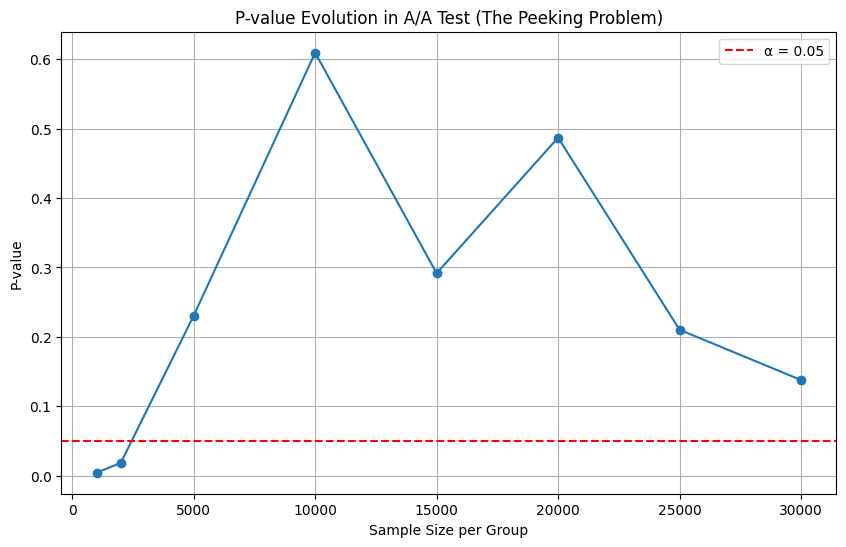

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, p_values_over_time, marker='o')
plt.axhline(y=0.05, color='r', linestyle='--', label='α = 0.05')
plt.xlabel('Sample Size per Group')
plt.ylabel('P-value')
plt.title('P-value Evolution in A/A Test (The Peeking Problem)')
plt.legend()
plt.grid(True)
plt.show()

# Multiple A/A Tests

A false positive in an A/A test occurs when we conclude there is a difference. This is because our null hypothesis would be that no real difference exists, and that should be true (samples are the same). Thus, when our p value < .05, we get a false positive. We are going to simulate the p value when we peek vs. when we don't peek. Theoretically, peeking should give us a higher false positive rate. 

In [31]:
n_simulations = 1000
fp_no_peeking = 0

fp_peeking = 0
sample_sizes = [5000, 10000, 15000, 20000, 25000, 30000]

#No Peeking
for i in range(n_simulations):
    shuffled = user_conversions.sample(frac = 1)
    group_a = shuffled.iloc[:30000]
    group_b = shuffled.iloc[30000:60000]

    conversions = np.array([group_a['converted'].sum(),
                          group_b['converted'].sum()])
    n_obs = np.array([len(group_a), len(group_b)])
    z_stat, p_value = proportions_ztest(conversions, n_obs)

    if p_value < .05:
        fp_no_peeking += 1

#Peeking
for i in range(n_simulations):
    shuffled = user_conversions.sample(frac = 1)
    group_a = shuffled.iloc[:30000]
    group_b = shuffled.iloc[30000:60000]
    stopped_early = False
    for n in sample_sizes:
        conversions = np.array([group_a.iloc[:n]['converted'].sum(),
                            group_b.iloc[:n]['converted'].sum()])
        n_obs = np.array([n, n])
        z_stat, p_value = proportions_ztest(conversions, n_obs)

        if p_value < .05:
            stopped_early = True
            break
    if stopped_early:
        fp_peeking += 1

fpr_no_peeking = fp_no_peeking / n_simulations
fpr_peeking = fp_peeking / n_simulations

print(f"False Positive Rate: {fpr_no_peeking:.4f}")
print(f"Is our FPR around .05? {(fpr_no_peeking < .06) and (fpr_no_peeking > .04)}")

print(f"False Positive Rate (with peeking): {fpr_peeking:.4f}")
print(f"Peaking and no peeking FPR difference: {fpr_peeking - fpr_no_peeking:.4f}")

    
    

False Positive Rate: 0.0420
Is our FPR around .05? True
False Positive Rate (with peeking): 0.1560
Peaking and no peeking FPR difference: 0.1140
